In [95]:
import torch
import torchvision
import os
import random

import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image

from transformers import BeitForImageClassification, BeitConfig, BeitFeatureExtractor, \
                         ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
from AutoAugment.autoaugment import ImageNetPolicy

from tqdm import tqdm
from collections import defaultdict, OrderedDict

In [96]:
# Check for GPU
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

device

'cuda:0'

In [97]:
df = pd.read_csv("../data/train_labels.csv", names=['img_name', 'label'], header=1)

df = df.append([df[df["label"] == 20]] * 15, ignore_index = True)
df = df.sample(frac=1).reset_index(drop=True)

df.shape

(31016, 2)

In [98]:
class food_set(Dataset):

    def __init__(self, df, labels_file, img_dir, extractor, transform = None, settype = "train"):
        self.df = df
        if settype == "train":
            self.img_labels = df[:29000]
        elif settype == "val":
            self.img_labels = df[29000:]
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
                
        features = self.feature_extractor(images=image)["pixel_values"][0]      
        
        label = self.img_labels.iloc[idx, 1]       
            
        return features, label

In [99]:
class food_test(Dataset):

    def __init__(self, img_dir, extractor, transform = None):
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        file_name = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path)        
        
        if self.transform:
            image = self.transform(image)
        
        features = self.feature_extractor(images=image)["pixel_values"][0]
        
        return file_name, features

In [100]:
# Load BEiT
beit = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224-pt22k-ft22k")

for param in beit.parameters():
    param.requires_grad = False

# classifier = nn.Sequential(OrderedDict([
#                           ('fc1', nn.Linear(768, 512)),
#                           ('relu', nn.ReLU()),
#                           ('fc2', nn.Linear(512, 81)),
#                           ('output', nn.LogSoftmax(dim=1))
#                           ]))

# beit.classifier = classifier

# beit.load_state_dict(torch.load("../../optimal_models/beit_2_fc_29k_30_epochs_imgnetpol.pth"))
# beit.to(device);

In [101]:
# Load ViT
vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

for param in vit.parameters():
    param.requires_grad = False

# vit.classifier = torch.nn.Linear(768, 81)

# vit.load_state_dict(torch.load("../../optimal_models/ViT_data_aug_locked_sets.pth"))
# vit.to(device);

In [102]:
# Load Densenet161
densenet = models.densenet161(pretrained=True)

for param in densenet.parameters():
    param.requires_grad = False

# densenet.cuda()

In [103]:
# Load Resnet18
resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

In [120]:
class ensemble(nn.Module):
    
    def __init__(self, BEiT, ViT, densenet161, resnet18):
        
        super(ensemble, self).__init__()
        
        self.beit = BEiT
        self.vit = ViT
        self.densenet = densenet161
        self.resnet = resnet18
        
        self.beit.classifier = nn.Identity()
        self.vit.classifier = nn.Identity()
        self.densenet.classifier = nn.Identity()
        
        
        self.classifier = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(768+768+2208+1000, 512)),
            ('relu', nn.ReLU()),
            ('fc2', nn.Linear(512, 81)),
            ('output', nn.LogSoftmax(dim=1))
        ]))
        
        
    def forward(self, image):
        
        x1 = self.beit(image)["logits"]
        x2 = self.vit(image)["logits"]        
        x3 = self.densenet(image)
        x4 = self.resnet(image)
               
        x = torch.cat((x1, x2, x3, x4), dim=1)
        
        x = self.classifier(x)
        
        return x

In [121]:
ensemble = ensemble(beit, vit, densenet, resnet)

ensemble.to(device);

In [122]:
def train_loop(trainloader, valloader, model, criterion, optimizer):
    
    # Train on GPU if available
    model = model.to(device)
    model.train()
    
    # Metadata
    stats = defaultdict(list)
    current_acc = 0
    max_acc = 0
    
    try:
        stats["epoch"].append(0)
        stats["loss"].append(5)
        stats["accuracy"].append(1.25)

        for epoch in range(5):
            size = len(trainloader.dataset)

            for batch, (image, label) in enumerate(trainloader):
                # Compute prediction and loss
                image, label = image.to(device), label.to(device)            
                pred = model(image)
                loss = criterion(pred, label)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Print progress
                if batch % 200 == 0:
                    loss, current = loss.item(), batch * len(image)
                    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] epoch: {epoch + 1}")

            # Print performance after current number of epochs
            print(f"Epoch: {epoch + 1}")
            current_acc, avg_loss = test_loop(valloader, model, criterion)

            if current_acc > max_acc:
                PATH = f'../../ensemble_2.pth'
                torch.save(model.state_dict(), PATH)
                max_acc = current_acc

            # Store metadata
            stats["epoch"].append(epoch + 1)
            stats["accuracy"].append(current_acc)
            stats["loss"].append(avg_loss)

            # Plot progress
            fig, ax1 = plt.subplots()

            color = "tab:blue"
            ax1.set_xlabel("Epoch")
            ax1.set_ylabel("Loss", color=color)
            ax1.plot(stats["epoch"], stats["loss"], color=color)
            ax1.tick_params(axis="y", labelcolor=color)

            ax2 = ax1.twinx()

            color = "tab:orange"
            ax2.set_ylabel("Accuracy", color=color)
            ax2.plot(stats["epoch"], stats["accuracy"], color=color)
            ax2.tick_params(axis="y", labelcolor=color)
            plt.show()

        return stats
    
    except KeyboardInterrupt:
        return stats


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            test_loss += criterion(pred, label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return (100 * correct), test_loss

In [123]:
# CrossEntropyLoss and SGD optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.classifier.parameters(), lr = 0.01, momentum = 0.9)
optimizer = optim.Adam(ensemble.classifier.parameters(), lr = 0.0002, betas=[0.9, 0.999])

In [124]:
img_dir = "../data/train_set/train_set"
labels = "../data/train_labels.csv"

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       ImageNetPolicy(),
                                       transforms.RandomHorizontalFlip()])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224)])

feature_extractor = BeitFeatureExtractor.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')

In [125]:
trainset = food_set(df, labels, img_dir, feature_extractor, transform = train_transforms, settype = "train")
valset = food_set(df, labels, img_dir, feature_extractor, transform = test_transforms, settype = "val")

# Create a DataLoader with the data
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=8, shuffle=True, num_workers=0)

len(trainset), len(valset)

(29000, 2016)

In [126]:
test_set = food_test("../data/test_set/test_set", feature_extractor)
testloader = DataLoader(test_set, batch_size = 8)

len(test_set)

7653

loss: 4.455701  [    0/29000] epoch: 1
loss: 3.040698  [ 1600/29000] epoch: 1
loss: 2.266646  [ 3200/29000] epoch: 1
loss: 1.679528  [ 4800/29000] epoch: 1
loss: 2.435607  [ 6400/29000] epoch: 1
loss: 2.072514  [ 8000/29000] epoch: 1
loss: 2.307375  [ 9600/29000] epoch: 1
loss: 1.481439  [11200/29000] epoch: 1
loss: 1.306799  [12800/29000] epoch: 1
loss: 1.034896  [14400/29000] epoch: 1
loss: 1.270853  [16000/29000] epoch: 1
loss: 2.793306  [17600/29000] epoch: 1
loss: 0.823481  [19200/29000] epoch: 1
loss: 1.433621  [20800/29000] epoch: 1
loss: 1.227817  [22400/29000] epoch: 1
loss: 2.141968  [24000/29000] epoch: 1
loss: 1.310421  [25600/29000] epoch: 1
loss: 1.147861  [27200/29000] epoch: 1
loss: 1.210548  [28800/29000] epoch: 1
Epoch: 1
Test Error: 
 Accuracy: 70.2%, Avg loss: 1.130887 



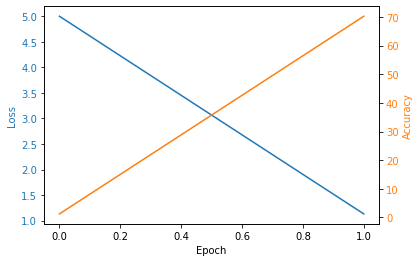

loss: 1.292403  [    0/29000] epoch: 2
loss: 1.496497  [ 1600/29000] epoch: 2
loss: 2.538502  [ 3200/29000] epoch: 2
loss: 2.532077  [ 4800/29000] epoch: 2
loss: 0.990452  [ 6400/29000] epoch: 2
loss: 0.643674  [ 8000/29000] epoch: 2
loss: 1.438220  [ 9600/29000] epoch: 2
loss: 1.625039  [11200/29000] epoch: 2
loss: 1.068116  [12800/29000] epoch: 2
loss: 1.166249  [14400/29000] epoch: 2
loss: 1.634175  [16000/29000] epoch: 2
loss: 1.330703  [17600/29000] epoch: 2
loss: 1.316173  [19200/29000] epoch: 2
loss: 1.361599  [20800/29000] epoch: 2
loss: 1.355939  [22400/29000] epoch: 2
loss: 0.967053  [24000/29000] epoch: 2
loss: 1.464228  [25600/29000] epoch: 2
loss: 1.383148  [27200/29000] epoch: 2
loss: 2.484748  [28800/29000] epoch: 2
Epoch: 2
Test Error: 
 Accuracy: 71.7%, Avg loss: 1.056814 



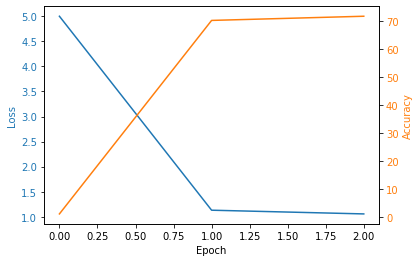

loss: 1.552156  [    0/29000] epoch: 3


In [127]:
stats = train_loop(trainloader, valloader, ensemble, criterion, optimizer)

In [ ]:
df_stats = pd.DataFrame(stats)
df_stats.to_csv("../../stats/ensemble_2.csv")

In [ ]:
# PATH = './transfered_beit.pth'
# torch.save(beit.state_dict(), PATH)

# beit.load_state_dict(torch.load("../../ensemble_2.pth"))
# beit.to(device)

In [43]:
test_results = {"img_name" : [], "label": []}

for file_name, image in tqdm(testloader):
    X = image.to(device)
    pred = ensemble(X).argmax(1)
    
    test_results["img_name"] += file_name
    test_results["label"] += [int(i) for i in pred.cpu()]

100%|████████████████████████████████████████| 957/957 [03:44<00:00,  4.27it/s]


In [44]:
test_df = pd.DataFrame(test_results)

test_df.head()

,img_name,label
0,test_1.jpg,63
1,test_10.jpg,45
2,test_100.jpg,48
3,test_1000.jpg,29
4,test_1001.jpg,18


In [45]:
test_df.to_csv("../../submissions/submission_ensemble_2.csv", index=False)